# Figure 3: Individual Trajectories

## Purpose
Demonstrate individual-specific disease trajectories and how signatures evolve over time.

## Panels Required:
- **Panel A:** Case studies of 2-3 individuals showing signature evolution
- **Panel B:** Multimorbidity patterns - how theta changes before vs. after diagnosis
- **Panel C:** Signature response to new diagnoses (real-time updating)
- **Panel D:** Comparison of trajectories between subtypes of same disease

## Key Message:
Show personalized trajectories and dynamic updating capabilities


In [4]:
# Setup
import sys
import os
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

print("Setup complete")


Setup complete


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_40900/220760027.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_clusters = torch.load('/Users/sarahur

Selected patient: 3


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_40900/220760027.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Saved plot to: patient_3_timeline_panel_style.pdf


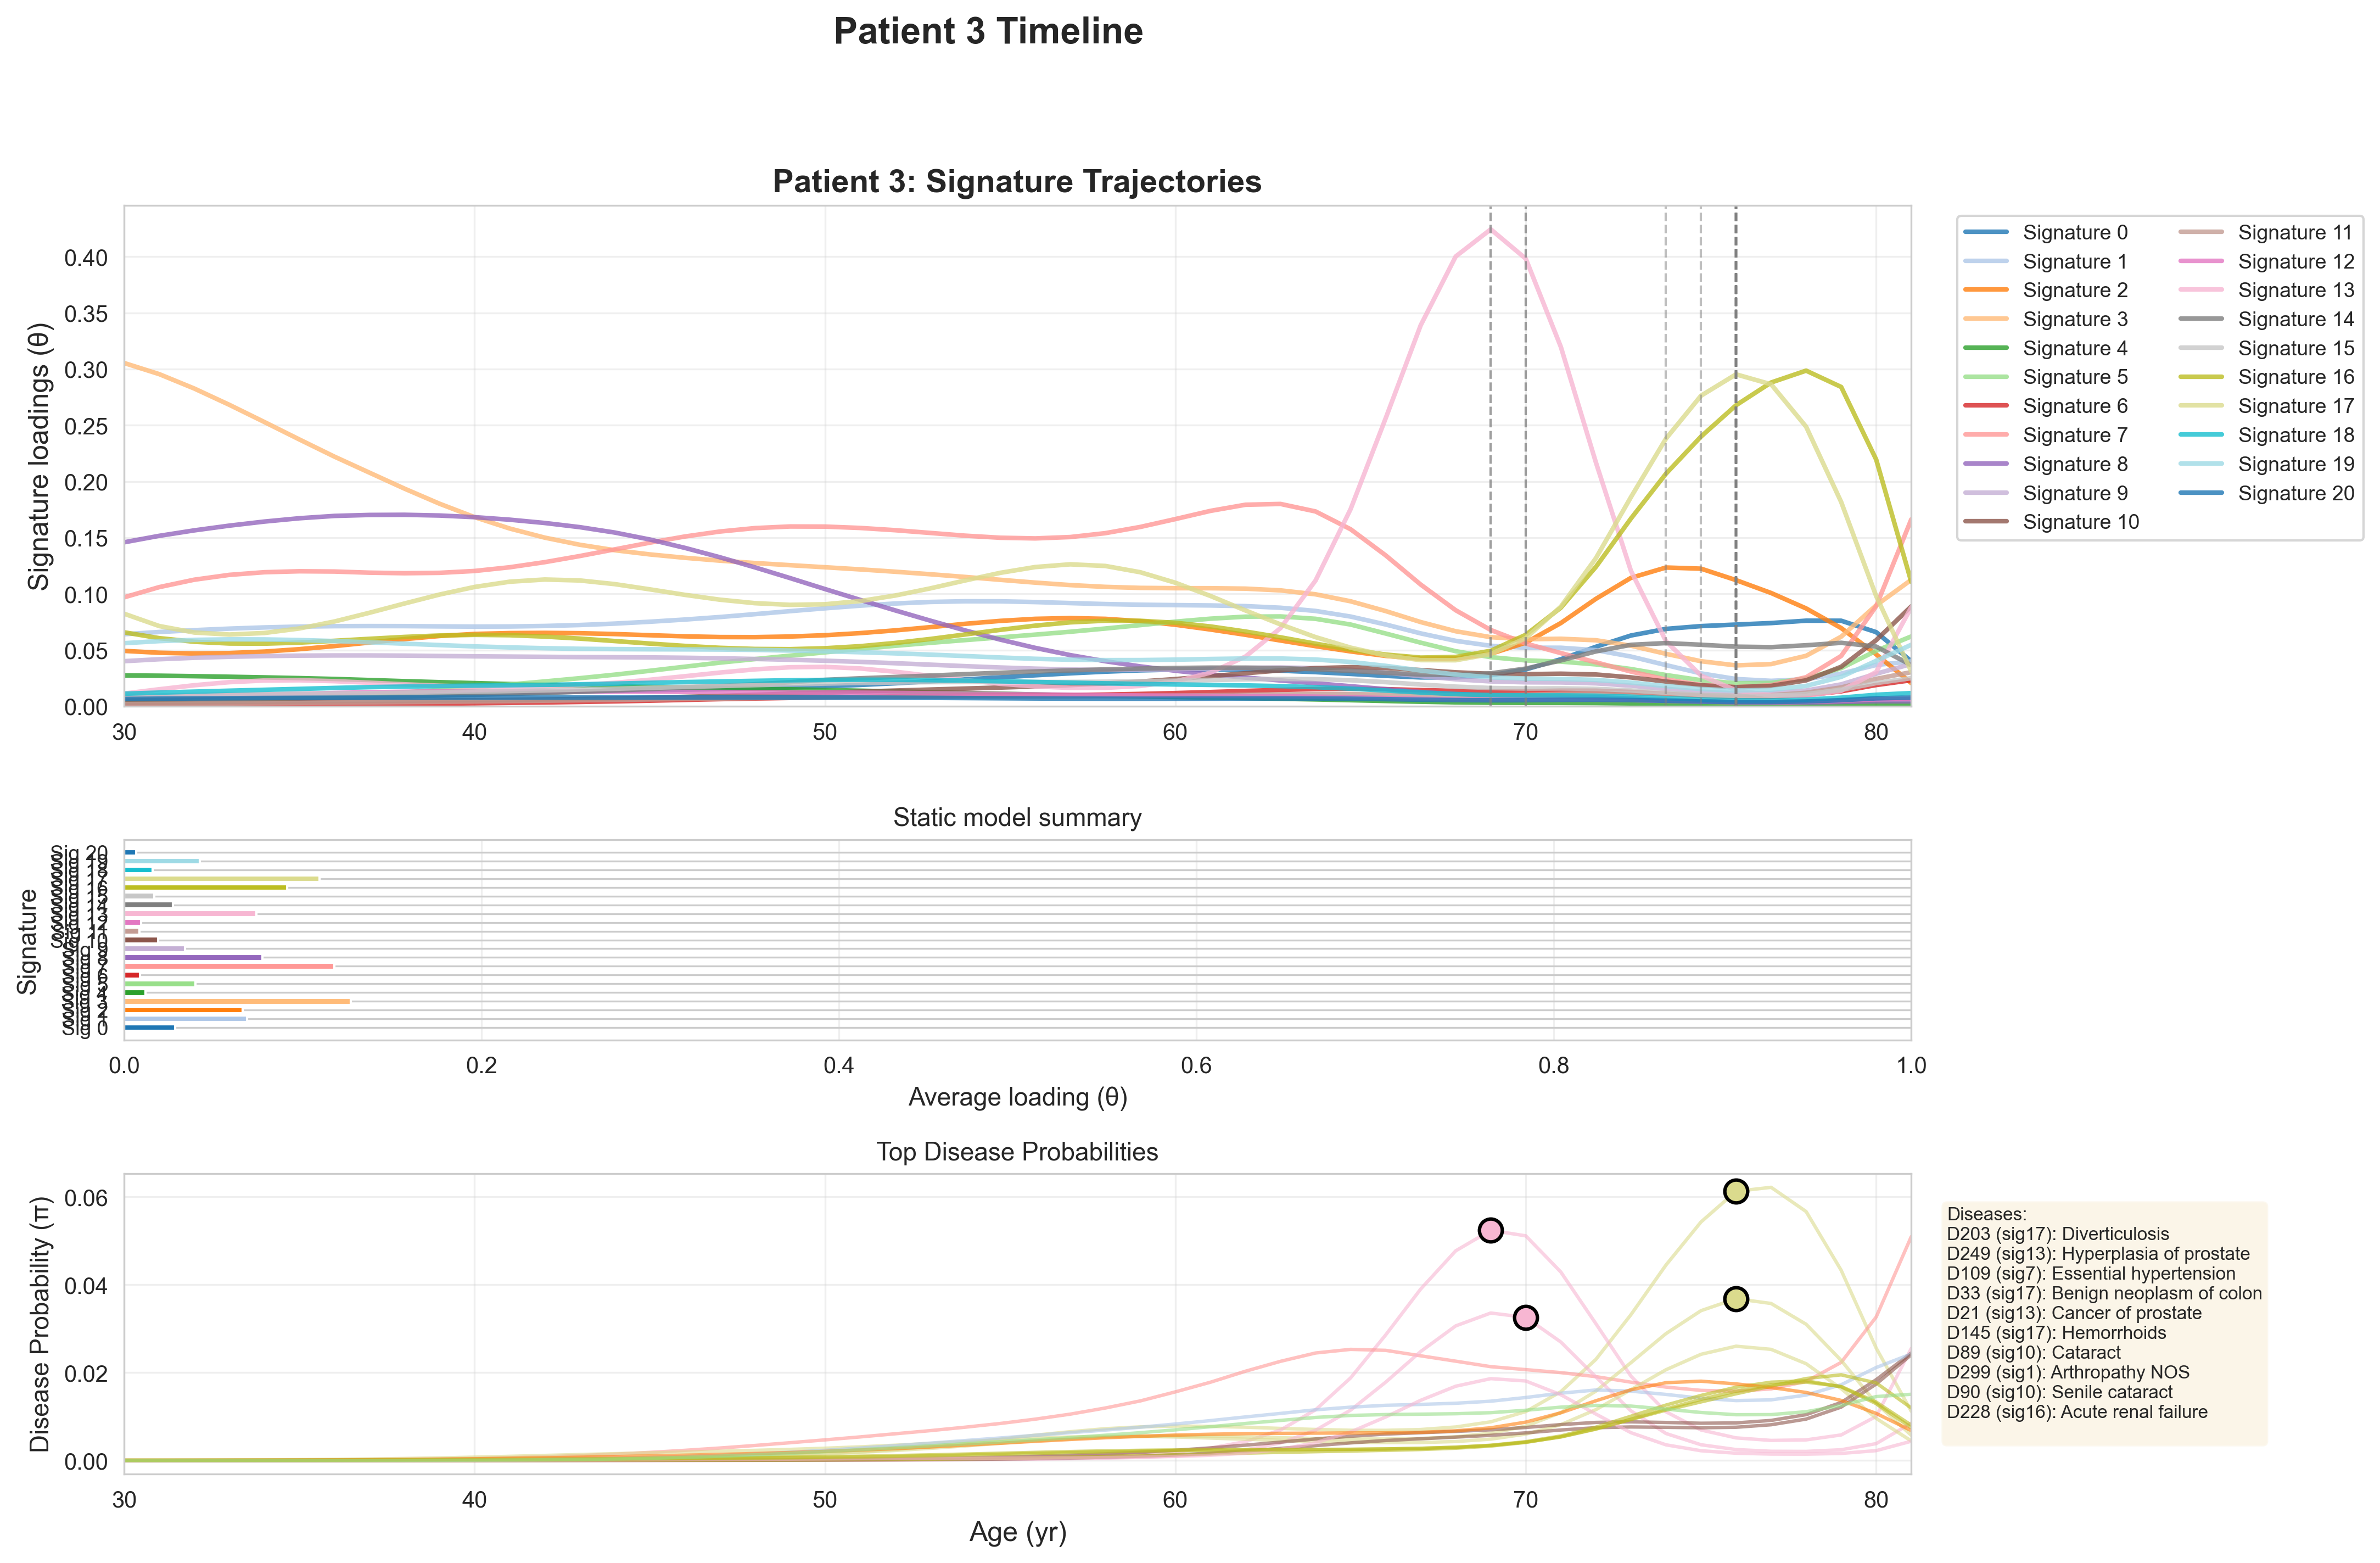

In [5]:
# ============================================================================
# Plot Patient Timeline (Panel A/B/C Style)
# ============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load data
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
if torch.is_tensor(initial_clusters):
    initial_clusters = initial_clusters.numpy()
K = int(initial_clusters.max() + 1)

checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt'
pi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/pi_fullmode_batch_0_10000.pt'

ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
lambda_ = ckpt['model_state_dict']['lambda_']
theta = torch.softmax(lambda_, dim=1).numpy()  # (N, K, T)
Y = ckpt['Y']
if torch.is_tensor(Y):
    Y_np = Y.numpy()
else:
    Y_np = Y

pi_full = torch.load(pi_path, map_location='cpu', weights_only=False)
if torch.is_tensor(pi_full):
    pi_np = pi_full.numpy()
else:
    pi_np = pi_full

# Load disease names if available
#disease_names = ckpt.get('disease_names', [f'Disease {i}' for i in range(Y_np.shape[1])])
disease_names=pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x'].tolist()
# Find patient with signature spike
N, K_total, T = theta.shape
patient_idx = None
for p_idx in range(N):
    max_theta = theta[p_idx, :, :].max()
    if max_theta > 0.4 and Y_np[p_idx, :, :].sum() > 0:
        patient_idx = p_idx
        break

if patient_idx is None:
    patient_idx = 0

print(f"Selected patient: {patient_idx}")

# Get patient data
patient_theta = theta[patient_idx, :, :]  # (K, T)
patient_pi = pi_np[patient_idx, :, :]  # (D, T)
patient_Y = Y_np[patient_idx, :, :]  # (D, T)

# Find diagnoses
diagnosis_times = {}
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diagnosis_times[d] = event_times.tolist()

# Convert timepoints to ages
ages = np.arange(30, 30 + T)

# ============================================================================
# Create Plot (Panel A/B/C Style)
# ============================================================================

fig = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(3, 1, height_ratios=[2, 0.8, 1.2], hspace=0.4)

# Panel 1: Signature loadings (θ) vs Age
ax1 = fig.add_subplot(gs[0])
colors = sns.color_palette("tab20", K_total)

for k in range(K_total):
    ax1.plot(ages, patient_theta[k, :], 
             label=f'Signature {k}', linewidth=2, color=colors[k], alpha=0.8)

# Mark diagnosis times
for d, times in diagnosis_times.items():
    for t in times:
        age_at_diag = 30 + t
        ax1.axvline(x=age_at_diag, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax1.set_ylabel('Signature loadings (θ)', fontsize=12)
ax1.set_title(f'Patient {patient_idx}: Signature Trajectories', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([30, 81])
ax1.set_ylim([0, None])

# Panel 2: Static model summary (Average loading bars)
ax2 = fig.add_subplot(gs[1])
avg_theta = patient_theta.mean(axis=1)  # Average across time
bars = ax2.barh(range(K_total), avg_theta, color=colors)
ax2.set_xlabel('Average loading (θ)', fontsize=11)
ax2.set_ylabel('Signature', fontsize=11)
ax2.set_yticks(range(K_total))
ax2.set_yticklabels([f'Sig {k}' for k in range(K_total)], fontsize=9)
ax2.set_xlim([0, 1])
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_title('Static model summary', fontsize=11)

# Panel 3: Disease timeline + Top pi values
ax3 = fig.add_subplot(gs[2])

# Top diseases by max pi
max_pi_per_disease = patient_pi.max(axis=1)
top_diseases = np.argsort(max_pi_per_disease)[::-1][:15]  # Top 15

# Plot pi for top diseases
for i, d in enumerate(top_diseases):
    sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
    color = colors[sig_for_disease] if sig_for_disease < K_total else 'gray'
    ax3.plot(ages, patient_pi[d, :], 
             linewidth=1.5, color=color, alpha=0.6, label=f'D{d}')

# Mark diagnoses
for d, times in diagnosis_times.items():
    if d in top_diseases:
        sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
        color = colors[sig_for_disease] if sig_for_disease < K_total else 'black'
        for t in times:
            age_at_diag = 30 + t
            ax3.scatter(age_at_diag, patient_pi[d, t], 
                       s=100, color=color, edgecolors='black', 
                       linewidth=1.5, zorder=10, marker='o')

ax3.set_xlabel('Age (yr)', fontsize=12)
ax3.set_ylabel('Disease Probability (π)', fontsize=11)
ax3.set_title('Top Disease Probabilities', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([30, 81])

# Add disease list on the right
disease_list_text = "Diseases:\n"
for d in top_diseases[:10]:
    sig = initial_clusters[d] if d < len(initial_clusters) else -1
    d_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
    disease_list_text += f"D{d} (sig{sig}): {d_name[:40]}\n"

ax3.text(1.02, 0.5, disease_list_text, transform=ax3.transAxes,
         fontsize=8, verticalalignment='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle(f'Patient {patient_idx} Timeline', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'/Users/sarahurbut/aladynoulli2/patient_{patient_idx}_timeline_panel_style.pdf', 
            dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plot to: patient_{patient_idx}_timeline_panel_style.pdf")
plt.show()

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_52526/2890917920.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_clusters = torch.load('/Users/sarahu

Selected patient: 4545
  Number of diseases: 75
  Diagnosis timepoints: [23, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
  Time range: 23 to 40 (ages 53 to 70)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_52526/2890917920.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Saved plot to: patient_4545_timeline_panel_style.pdf


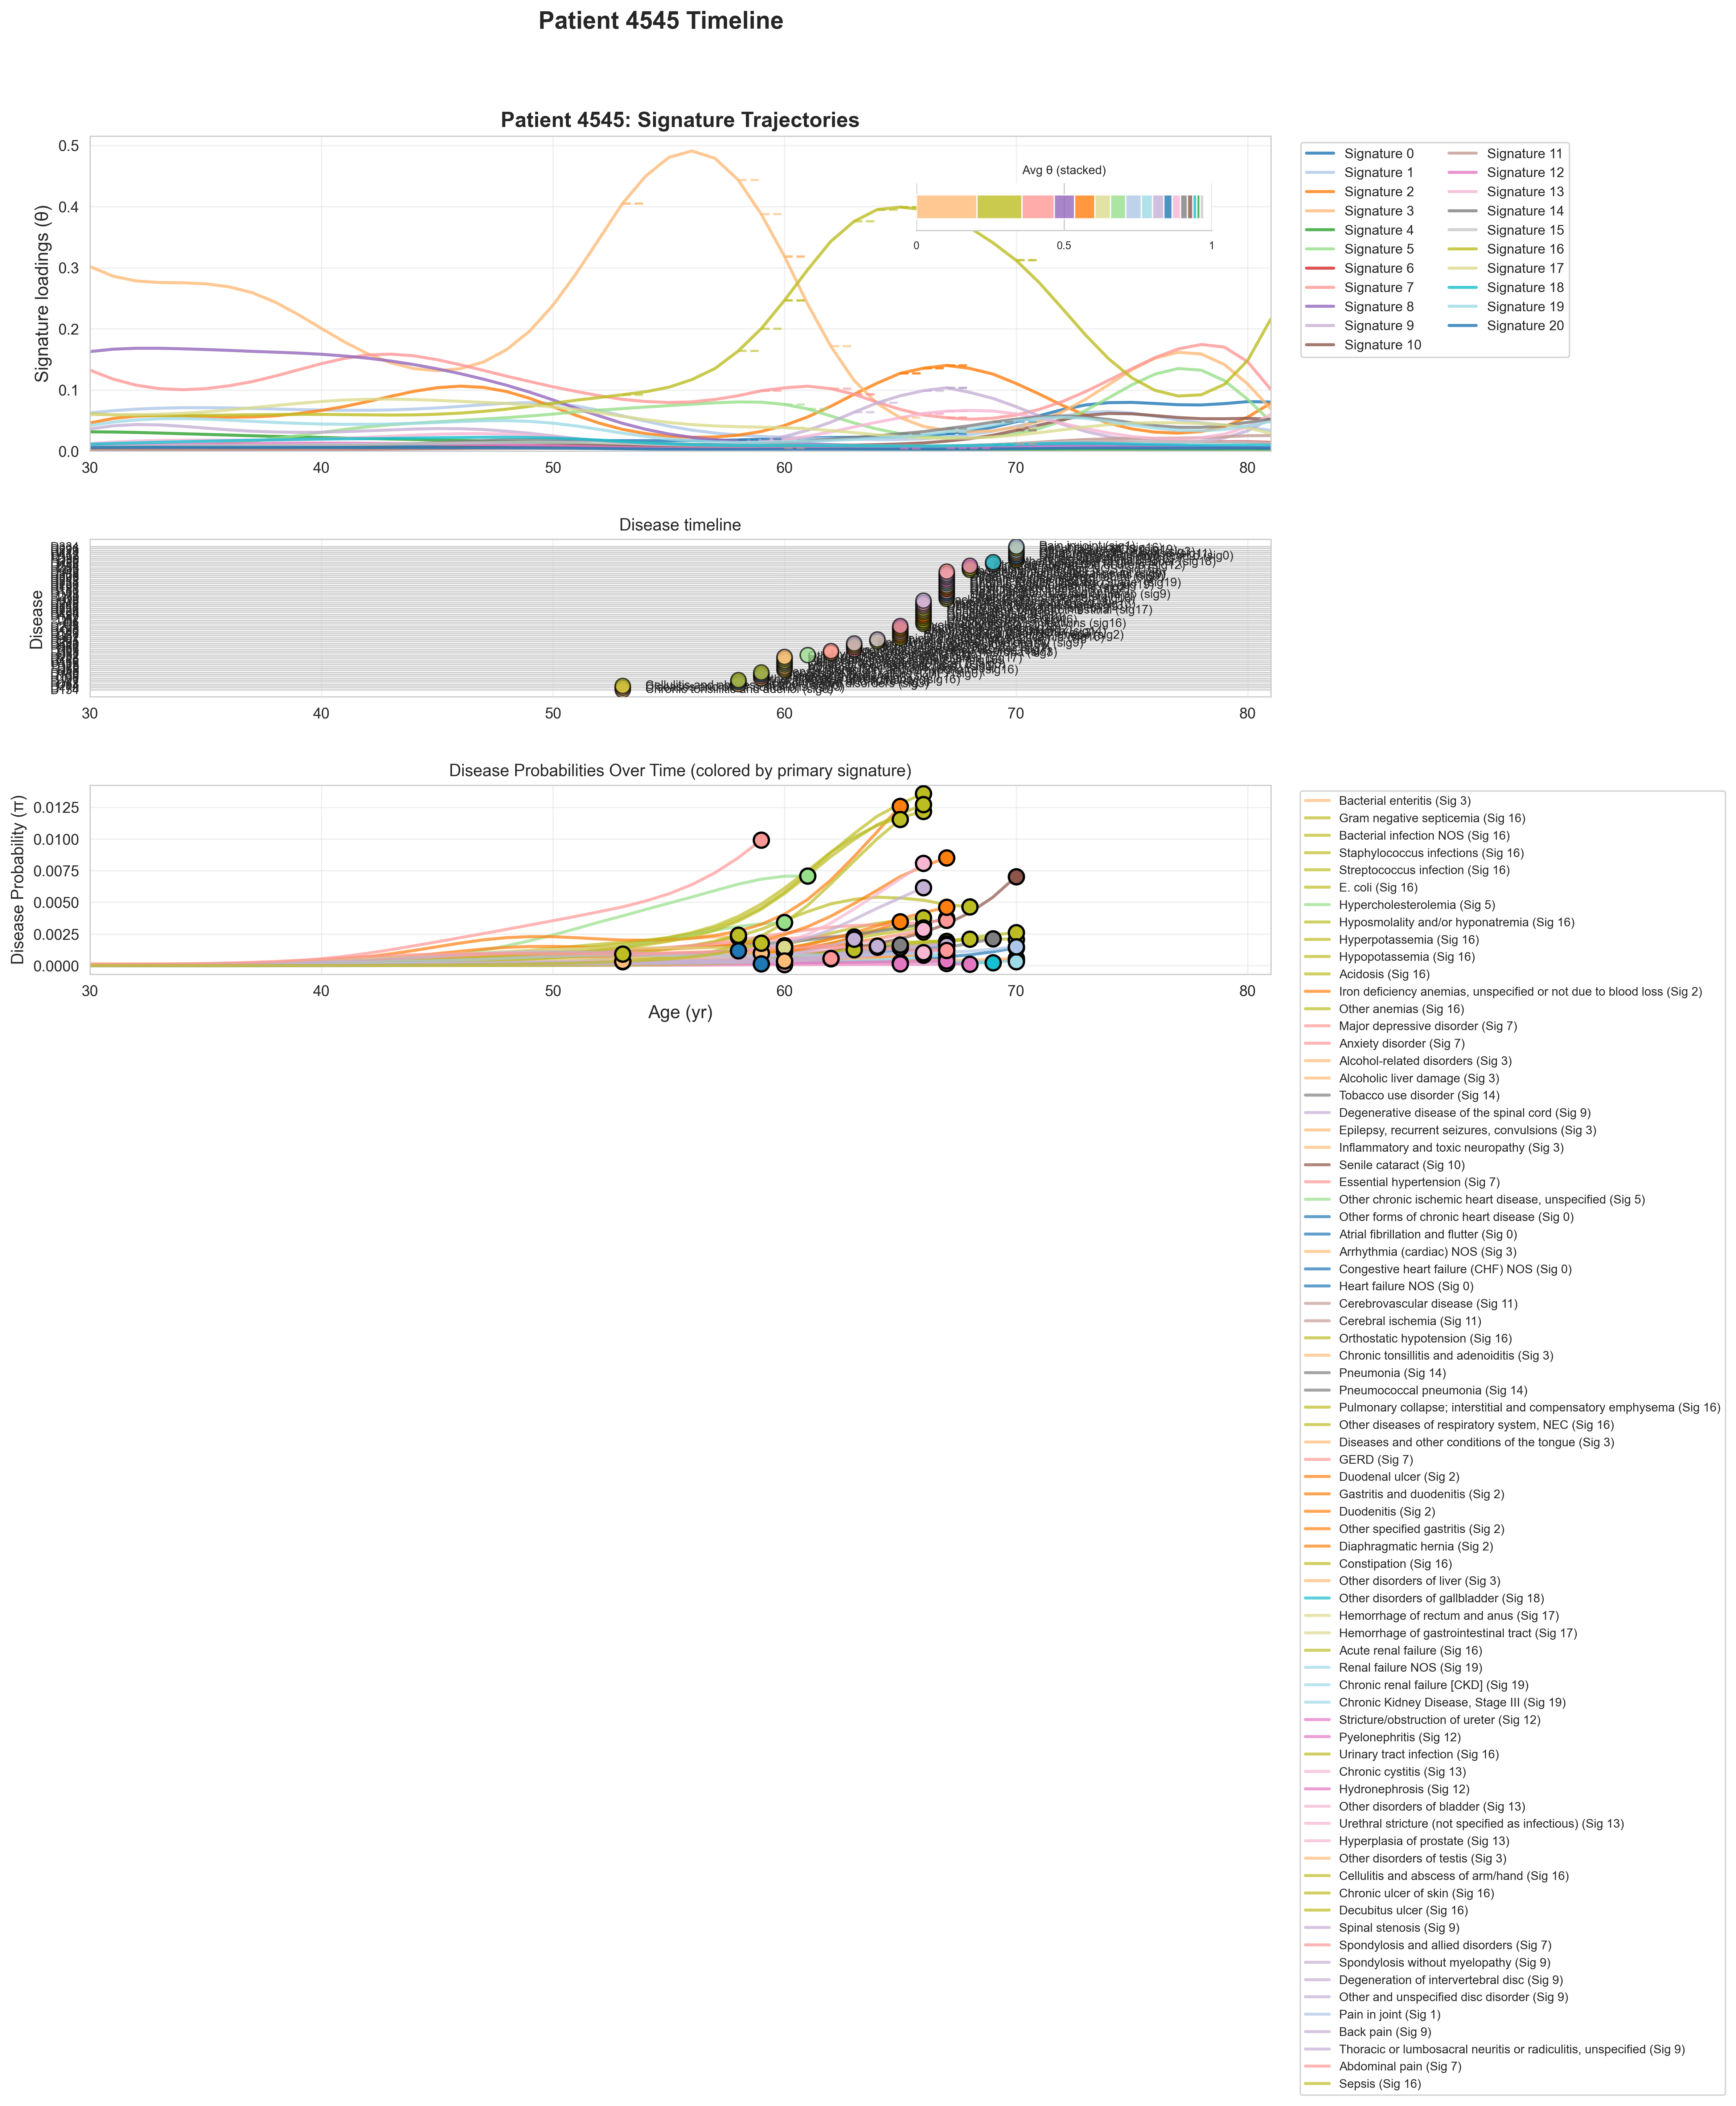

In [ ]:
# ============================================================================
# Plot Patient Timeline - Updated Layout
# ============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load data
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
if torch.is_tensor(initial_clusters):
    initial_clusters = initial_clusters.numpy()
K = int(initial_clusters.max() + 1)

checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt'
pi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/pi_fullmode_batch_0_10000.pt'

ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
lambda_ = ckpt['model_state_dict']['lambda_']
theta = torch.softmax(lambda_, dim=1).numpy()  # (N, K, T)
Y = ckpt['Y']
if torch.is_tensor(Y):
    Y_np = Y.numpy()
else:
    Y_np = Y

pi_full = torch.load(pi_path, map_location='cpu', weights_only=False)
if torch.is_tensor(pi_full):
    pi_np = pi_full.numpy()
else:
    pi_np = pi_full

# Load disease names
disease_names = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x'].tolist()

# Find patient with signature spike
# Find patient with multiple diseases at different times
N, K_total, T = theta.shape
patient_idx = None
best_score = 0

for p_idx in range(N):
    # Count number of diseases with events
    patient_Y_single = Y_np[p_idx, :, :]
    diseases_with_events = np.where(patient_Y_single.sum(axis=1) > 0)[0]
    n_diseases = len(diseases_with_events)
    
    if n_diseases < 5:  # Need at least 5 diseases
        continue
    
    # Get diagnosis times for all diseases
    diagnosis_times_list = []
    for d in diseases_with_events:
        event_times = np.where(patient_Y_single[d, :] == 1)[0]
        if len(event_times) > 0:
            diagnosis_times_list.extend(event_times.tolist())
    
    if len(diagnosis_times_list) == 0:
        continue
    
    # Calculate spread of diagnosis times (want diagnoses spread across time)
    diagnosis_times_array = np.array(diagnosis_times_list)
    time_spread = diagnosis_times_array.max() - diagnosis_times_array.min()
    
    # Calculate diversity: want diagnoses at different timepoints
    unique_times = len(np.unique(diagnosis_times_array))
    
    # Score: prioritize more diseases, more spread, more unique timepoints
    score = n_diseases * 10 + time_spread * 2 + unique_times * 5
    
    if score > best_score:
        best_score = score
        patient_idx = p_idx

if patient_idx is None:
    # Fallback: find any patient with multiple diseases
    for p_idx in range(N):
        patient_Y_single = Y_np[p_idx, :, :]
        n_diseases = np.where(patient_Y_single.sum(axis=1) > 0)[0].shape[0]
        if n_diseases >= 3:
            patient_idx = p_idx
            break

if patient_idx is None:
    patient_idx = 0

print(f"Selected patient: {patient_idx}")

# Get patient data
patient_theta = theta[patient_idx, :, :]  # (K, T)
patient_pi = pi_np[patient_idx, :, :]  # (D, T)
patient_Y = Y_np[patient_idx, :, :]  # (D, T)

# Find diagnoses
diagnosis_times = {}
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diagnosis_times[d] = event_times.tolist()

# Print summary
n_diseases = len(diagnosis_times)
all_times = []
for times in diagnosis_times.values():
    all_times.extend(times)
time_range = (min(all_times), max(all_times)) if all_times else (0, 0)
print(f"  Number of diseases: {n_diseases}")
print(f"  Diagnosis timepoints: {sorted(set(all_times))}")
print(f"  Time range: {time_range[0]} to {time_range[1]} (ages {30+time_range[0]} to {30+time_range[1]})")

# Get patient data
patient_theta = theta[patient_idx, :, :]  # (K, T)
patient_pi = pi_np[patient_idx, :, :]  # (D, T)
patient_Y = Y_np[patient_idx, :, :]  # (D, T)

# Calculate average theta (K vector) - average across time
avg_theta = patient_theta.mean(axis=1)  # Shape: (K,)

# Find diseases with events
diseases_with_events = []
diagnosis_times = {}
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diseases_with_events.append(d)
        diagnosis_times[d] = event_times.tolist()

# Convert timepoints to ages
ages = np.arange(30, 30 + T)

# ============================================================================
# Create Plot
# ============================================================================

fig = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1.2], hspace=0.4)

colors = sns.color_palette("tab20", K_total)
sig_colors = sns.color_palette("tab20", K_total)

# Panel 1: Signature loadings (θ) vs Age
ax1 = fig.add_subplot(gs[0])
colors = sns.color_palette("tab20", K_total)

for k in range(K_total):
    ax1.plot(ages, patient_theta[k, :], 
             label=f'Signature {k}', linewidth=2, color=colors[k], alpha=0.8)

# Add horizontal lines at diagnosis times
for d, times in diagnosis_times.items():
    for t in times:
        age_at_diag = 30 + t
        # Get the signature for this disease
        sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
        if sig_for_disease < K_total:
            # Draw horizontal line at the theta value for this signature at diagnosis time
            theta_at_diag = patient_theta[sig_for_disease, t]
            ax1.axhline(y=theta_at_diag, xmin=(age_at_diag - 30) / (81 - 30), 
                       xmax=(age_at_diag - 30 + 1) / (81 - 30),
                       color=colors[sig_for_disease], linestyle='--', 
                       alpha=0.6, linewidth=1.5)

# Add thin stacked bar showing average theta (single bar, stacked)
# Position it at the top right
ax1_bar = ax1.inset_axes([0.7, 0.7, 0.25, 0.15])  # [x, y, width, height] in axes coordinates

# Sort signatures by average theta (largest first) for better visualization
sorted_indices = np.argsort(avg_theta)[::-1]
sorted_avg_theta = avg_theta[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# Create stacked bar (single bar)
bottom = 0
for i, (val, color) in enumerate(zip(sorted_avg_theta, sorted_colors)):
    if val > 0.01:  # Only show if > 1% to avoid clutter
        ax1_bar.barh(0, val, left=bottom, color=color, height=0.5, alpha=0.8)
        bottom += val

ax1_bar.set_xlim([0, 1])
ax1_bar.set_ylim([-0.5, 0.5])
ax1_bar.set_xticks([0, 0.5, 1.0])
ax1_bar.set_xticklabels(['0', '0.5', '1'], fontsize=7)
ax1_bar.set_yticks([])
ax1_bar.set_title('Avg θ (stacked)', fontsize=8)
ax1_bar.spines['top'].set_visible(False)
ax1_bar.spines['right'].set_visible(False)
ax1_bar.spines['left'].set_visible(False)

ax1.set_ylabel('Signature loadings (θ)', fontsize=12)
ax1.set_title(f'Patient {patient_idx}: Signature Trajectories', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([30, 81])
ax1.set_ylim([0, None])

# Panel 2: Disease timeline (scatter plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

if len(diagnosis_times) > 0:
    # Sort diagnoses by time
    diag_order = sorted([(d, times[0]) for d, times in diagnosis_times.items()], 
                       key=lambda x: x[1])
    disease_rows = {d: i for i, (d, _) in enumerate(diag_order)}
    
    for d, t_diag in diag_order:
        sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
        color = sig_colors[sig_for_disease] if sig_for_disease < K_total else 'gray'
        age_at_diag = 30 + t_diag
        y = disease_rows[d]
        disease_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
        ax2.scatter(age_at_diag, y, s=100, color=color, alpha=0.7, zorder=10, 
                   edgecolors='black', linewidths=1)
        ax2.text(age_at_diag + 1, y, f'{disease_name[:30]} (sig{sig_for_disease})', 
                fontsize=8, verticalalignment='center')
    
    ax2.set_yticks(range(len(diag_order)))
    # Label diseases by chronological order (1, 2, 3, ...)
    ax2.set_yticklabels([f'{i+1}' for i in range(len(diag_order))], fontsize=8)
else:
    ax2.text(0.5, 0.5, 'No diagnoses', transform=ax2.transAxes, 
            ha='center', va='center', fontsize=12)

ax2.set_ylabel('Disease', fontsize=11)
ax2.set_title('Disease timeline', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim([30, 81])

# Panel 3: Disease probabilities (π) - stop after diagnosis
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Plot diseases with events, colored by signature, stopping after diagnosis
for d in diseases_with_events:
    disease_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
    sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
    color = sig_colors[sig_for_disease] if sig_for_disease < K_total else 'gray'
    
    # Get diagnosis timepoint
    if d in diagnosis_times:
        first_diag_t = min(diagnosis_times[d])
        # Only plot up to and including diagnosis timepoint
        plot_ages = ages[:first_diag_t + 1]
        plot_pi = patient_pi[d, :first_diag_t + 1]
    else:
        plot_ages = ages
        plot_pi = patient_pi[d, :]
    
    # Plot probability curve (stops after diagnosis)
    ax3.plot(plot_ages, plot_pi, 
             label=f"{disease_name} (Sig {sig_for_disease})",
             color=color, linewidth=2, alpha=0.7)
    
    # Mark diagnosis timepoint
    if d in diagnosis_times:
        for t in diagnosis_times[d]:
            age_at_diag = 30 + t
            ax3.scatter(age_at_diag, patient_pi[d, t], 
                       color=color, s=100, zorder=10, marker='o', 
                       edgecolors='black', linewidths=1.5)

ax3.set_xlabel('Age (yr)', fontsize=12)
ax3.set_ylabel('Disease Probability (π)', fontsize=11)
ax3.set_title('Disease Probabilities Over Time (colored by primary signature)', fontsize=11)
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([30, 81])

plt.suptitle(f'Patient {patient_idx} Timeline', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'/Users/sarahurbut/aladynoulli2/patient_{patient_idx}_timeline_panel_style.pdf', 
            dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plot to: patient_{patient_idx}_timeline_panel_style.pdf")
plt.show()

In [25]:
# Find patient with multiple diseases at different times
N, K_total, T = theta.shape
patient_idx = None
best_score = 0

for p_idx in range(N):
    # Count number of diseases with events
    patient_Y_single = Y_np[p_idx, :, :]
    diseases_with_events = np.where(patient_Y_single.sum(axis=1) > 0)[0]
    n_diseases = len(diseases_with_events)
    
    if n_diseases < 5:  # Need at least 5 diseases
        continue
    
    # Get diagnosis times for all diseases
    diagnosis_times_list = []
    for d in diseases_with_events:
        event_times = np.where(patient_Y_single[d, :] == 1)[0]
        if len(event_times) > 0:
            diagnosis_times_list.extend(event_times.tolist())
    
    if len(diagnosis_times_list) == 0:
        continue
    
    # Calculate spread of diagnosis times (want diagnoses spread across time)
    diagnosis_times_array = np.array(diagnosis_times_list)
    time_spread = diagnosis_times_array.max() - diagnosis_times_array.min()
    
    # Calculate diversity: want diagnoses at different timepoints
    unique_times = len(np.unique(diagnosis_times_array))
    
    # Score: prioritize more diseases, more spread, more unique timepoints
    score = n_diseases * 10 + time_spread * 2 + unique_times * 5
    
    if score > best_score:
        best_score = score
        patient_idx = p_idx

if patient_idx is None:
    # Fallback: find any patient with multiple diseases
    for p_idx in range(N):
        patient_Y_single = Y_np[p_idx, :, :]
        n_diseases = np.where(patient_Y_single.sum(axis=1) > 0)[0].shape[0]
        if n_diseases >= 3:
            patient_idx = p_idx
            break

if patient_idx is None:
    patient_idx = 0

print(f"Selected patient: {patient_idx}")

# Get patient data
patient_theta = theta[patient_idx, :, :]  # (K, T)
patient_pi = pi_np[patient_idx, :, :]  # (D, T)
patient_Y = Y_np[patient_idx, :, :]  # (D, T)

# Find diagnoses
diagnosis_times = {}
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diagnosis_times[d] = event_times.tolist()

# Print summary
n_diseases = len(diagnosis_times)
all_times = []
for times in diagnosis_times.values():
    all_times.extend(times)
time_range = (min(all_times), max(all_times)) if all_times else (0, 0)
print(f"  Number of diseases: {n_diseases}")
print(f"  Diagnosis timepoints: {sorted(set(all_times))}")
print(f"  Time range: {time_range[0]} to {time_range[1]} (ages {30+time_range[0]} to {30+time_range[1]})")

Selected patient: 4545
  Number of diseases: 75
  Diagnosis timepoints: [23, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
  Time range: 23 to 40 (ages 53 to 70)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61158/3339306270.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_clusters = torch.load('/Users/sarahu

Theta shape: (400000, 21, 52)
Y shape: (407878, 348, 52)
Pi shape: (400000, 348, 52)

Requested patient index: 148745

Using T = 52 (aligned across all arrays)

Patient 148745 Summary:
  Number of diseases: 20
  Diagnosis timepoints: [25, 26, 31, 33, 36, 38, 39, 40, 42, 46]
  Time range: 25 to 46 (ages 55 to 76)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61158/3339306270.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Saved plot to: patient_148745_timeline_panel_style.pdf


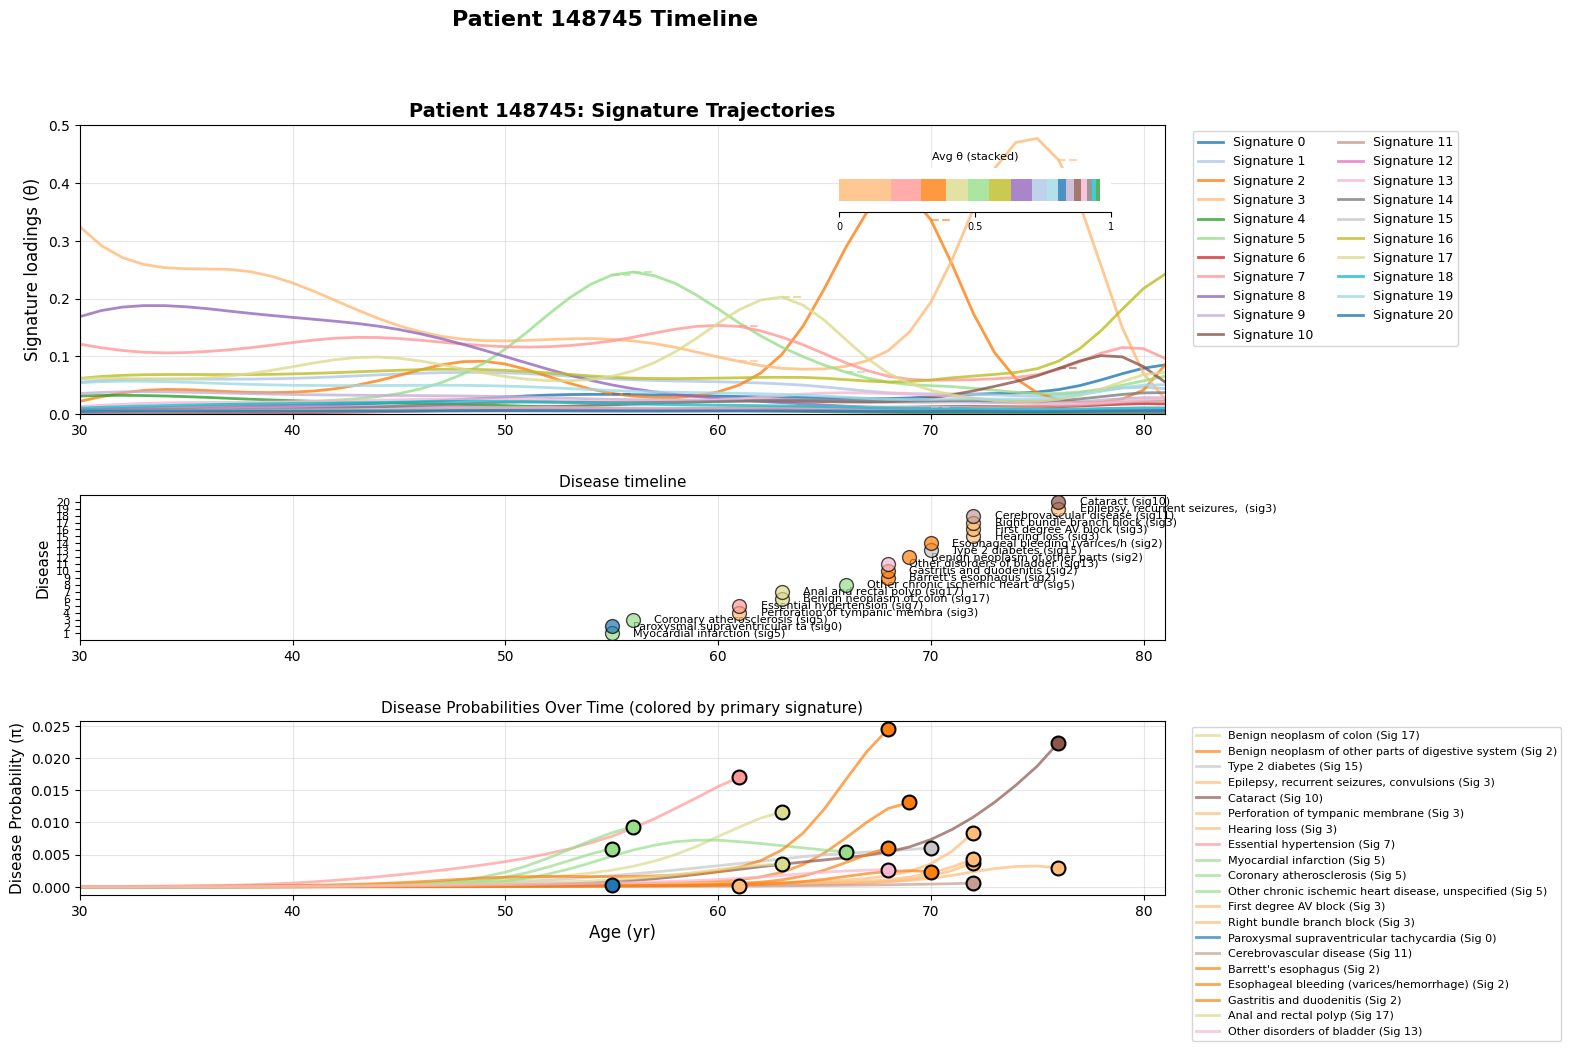

In [5]:
# ============================================================================
# Plot Patient Timeline - Updated Layout
# ============================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Load data
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
if torch.is_tensor(initial_clusters):
    initial_clusters = initial_clusters.numpy()
K = int(initial_clusters.max() + 1)

# Load theta from the specified file
theta_path = '/Users/sarahurbut/aladynoulli2/pyScripts/new_thetas_with_pcs_retrospective_correctE.pt'
theta_full = torch.load(theta_path, map_location='cpu', weights_only=False)

# Check structure of theta file
if isinstance(theta_full, dict):
    # If it's a dict, try common keys
    if 'theta' in theta_full:
        theta = theta_full['theta']
    elif 'thetas' in theta_full:
        theta = theta_full['thetas']
    elif 'lambda_' in theta_full:
        theta = torch.softmax(theta_full['lambda_'], dim=1)
    else:
        # Try first tensor value
        theta = list(theta_full.values())[0]
        if torch.is_tensor(theta) and theta.dim() == 3:
            theta = torch.softmax(theta, dim=1)
else:
    theta = theta_full

# Convert to numpy if needed
if torch.is_tensor(theta):
    theta = theta.numpy()
elif isinstance(theta, list):
    theta = np.array(theta)

# Load Y and pi from checkpoint (for patient 148746)
# Load Y and pi from checkpoint (for patient 148746)
checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt'
pi_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/pi_fullmode_400k.pt'

ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
Y = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
if torch.is_tensor(Y):
    Y_np = Y.numpy()
else:
    Y_np = Y

pi_full = torch.load(pi_path, map_location='cpu', weights_only=False)
if torch.is_tensor(pi_full):
    pi_np = pi_full.numpy()
else:
    pi_np = pi_full

# Load disease names
disease_names = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x'].tolist()

# Set patient index to 148746
patient_idx = 148745

# Check dimensions
N_theta, K_total, T_theta = theta.shape
N_y, D, T_y = Y_np.shape
N_pi, D_pi, T_pi = pi_np.shape

print(f"Theta shape: ({N_theta}, {K_total}, {T_theta})")
print(f"Y shape: ({N_y}, {D}, {T_y})")
print(f"Pi shape: ({N_pi}, {D_pi}, {T_pi})")
print(f"\nRequested patient index: {patient_idx}")

# Verify patient index is valid
if patient_idx >= N_theta:
    print(f"WARNING: Patient {patient_idx} not in theta array (max index: {N_theta-1})")
    patient_idx = min(patient_idx, N_theta - 1)
    print(f"Using patient index: {patient_idx}")

if patient_idx >= N_y:
    print(f"WARNING: Patient {patient_idx} not in Y array (max index: {N_y-1})")
    # We'll handle this below

if patient_idx >= N_pi:
    print(f"WARNING: Patient {patient_idx} not in pi array (max index: {N_pi-1})")
    # We'll handle this below

# Get patient data
patient_theta = theta[patient_idx, :, :]  # (K, T)
patient_Y = Y_np[patient_idx, :, :] if patient_idx < N_y else np.zeros((D, T_y))  # (D, T)
patient_pi = pi_np[patient_idx, :, :] if patient_idx < N_pi else np.zeros((D_pi, T_pi))  # (D, T)

# Ensure T dimensions match (use minimum)
T = min(T_theta, T_y, T_pi)
if T_theta != T:
    patient_theta = patient_theta[:, :T]
if T_y != T:
    patient_Y = patient_Y[:, :T]
if T_pi != T:
    patient_pi = patient_pi[:, :T]

print(f"\nUsing T = {T} (aligned across all arrays)")

# Find diagnoses
diagnosis_times = {}
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diagnosis_times[d] = event_times.tolist()

# Print summary
n_diseases = len(diagnosis_times)
all_times = []
for times in diagnosis_times.values():
    all_times.extend(times)
time_range = (min(all_times), max(all_times)) if all_times else (0, 0)
print(f"\nPatient {patient_idx} Summary:")
print(f"  Number of diseases: {n_diseases}")
print(f"  Diagnosis timepoints: {sorted(set(all_times))}")
print(f"  Time range: {time_range[0]} to {time_range[1]} (ages {30+time_range[0]} to {30+time_range[1]})")

# Calculate average theta (K vector) - average across time
avg_theta = patient_theta.mean(axis=1)  # Shape: (K,)

# Find diseases with events
diseases_with_events = []
for d in range(patient_Y.shape[0]):
    event_times = np.where(patient_Y[d, :] == 1)[0]
    if len(event_times) > 0:
        diseases_with_events.append(d)
        if d not in diagnosis_times:
            diagnosis_times[d] = event_times.tolist()

# Convert timepoints to ages
ages = np.arange(30, 30 + T)

# ============================================================================
# Create Plot
# ============================================================================

fig = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1.2], hspace=0.4)

colors = sns.color_palette("tab20", K_total)
sig_colors = sns.color_palette("tab20", K_total)

# Panel 1: Signature loadings (θ) vs Age
ax1 = fig.add_subplot(gs[0])

for k in range(K_total):
    ax1.plot(ages, patient_theta[k, :], 
             label=f'Signature {k}', linewidth=2, color=colors[k], alpha=0.8)

# Add horizontal lines at diagnosis times
for d, times in diagnosis_times.items():
    for t in times:
        if t >= T:
            continue
        age_at_diag = 30 + t
        # Get the signature for this disease
        sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
        if sig_for_disease < K_total:
            # Draw horizontal line at the theta value for this signature at diagnosis time
            theta_at_diag = patient_theta[sig_for_disease, t]
            ax1.axhline(y=theta_at_diag, xmin=(age_at_diag - 30) / (81 - 30), 
                       xmax=(age_at_diag - 30 + 1) / (81 - 30),
                       color=colors[sig_for_disease], linestyle='--', 
                       alpha=0.6, linewidth=1.5)

# Add thin stacked bar showing average theta (single bar, stacked)
# Position it at the top right
ax1_bar = ax1.inset_axes([0.7, 0.7, 0.25, 0.15])  # [x, y, width, height] in axes coordinates

# Sort signatures by average theta (largest first) for better visualization
sorted_indices = np.argsort(avg_theta)[::-1]
sorted_avg_theta = avg_theta[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# Create stacked bar (single bar)
bottom = 0
for i, (val, color) in enumerate(zip(sorted_avg_theta, sorted_colors)):
    if val > 0.01:  # Only show if > 1% to avoid clutter
        ax1_bar.barh(0, val, left=bottom, color=color, height=0.5, alpha=0.8)
        bottom += val

ax1_bar.set_xlim([0, 1])
ax1_bar.set_ylim([-0.5, 0.5])
ax1_bar.set_xticks([0, 0.5, 1.0])
ax1_bar.set_xticklabels(['0', '0.5', '1'], fontsize=7)
ax1_bar.set_yticks([])
ax1_bar.set_title('Avg θ (stacked)', fontsize=8)
ax1_bar.spines['top'].set_visible(False)
ax1_bar.spines['right'].set_visible(False)
ax1_bar.spines['left'].set_visible(False)

ax1.set_ylabel('Signature loadings (θ)', fontsize=12)
ax1.set_title(f'Patient {patient_idx}: Signature Trajectories', fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([30, 81])
ax1.set_ylim([0, None])

# Panel 2: Disease timeline (scatter plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

if len(diagnosis_times) > 0:
    # Sort diagnoses by time
    diag_order = sorted([(d, times[0]) for d, times in diagnosis_times.items()], 
                       key=lambda x: x[1])
    disease_rows = {d: i for i, (d, _) in enumerate(diag_order)}
    
    for d, t_diag in diag_order:
        if t_diag >= T:
            continue
        sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
        color = sig_colors[sig_for_disease] if sig_for_disease < K_total else 'gray'
        age_at_diag = 30 + t_diag
        y = disease_rows[d]
        disease_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
        ax2.scatter(age_at_diag, y, s=100, color=color, alpha=0.7, zorder=10, 
                   edgecolors='black', linewidths=1)
        ax2.text(age_at_diag + 1, y, f'{disease_name[:30]} (sig{sig_for_disease})', 
                fontsize=8, verticalalignment='center')
    
    ax2.set_yticks(range(len(diag_order)))
    # Label diseases by chronological order (1, 2, 3, ...)
    ax2.set_yticklabels([f'{i+1}' for i in range(len(diag_order))], fontsize=8)
else:
    ax2.text(0.5, 0.5, 'No diagnoses', transform=ax2.transAxes, 
            ha='center', va='center', fontsize=12)

ax2.set_ylabel('Disease', fontsize=11)
ax2.set_title('Disease timeline', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim([30, 81])

# Panel 3: Disease probabilities (π) - stop after diagnosis
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Plot diseases with events, colored by signature, stopping after diagnosis
for d in diseases_with_events:
    disease_name = disease_names[d] if d < len(disease_names) else f'Disease {d}'
    sig_for_disease = initial_clusters[d] if d < len(initial_clusters) else -1
    color = sig_colors[sig_for_disease] if sig_for_disease < K_total else 'gray'
    
    # Get diagnosis timepoint
    if d in diagnosis_times:
        first_diag_t = min(diagnosis_times[d])
        if first_diag_t >= T:
            first_diag_t = T - 1
        # Only plot up to and including diagnosis timepoint
        plot_ages = ages[:first_diag_t + 1]
        plot_pi = patient_pi[d, :first_diag_t + 1]
    else:
        plot_ages = ages
        plot_pi = patient_pi[d, :]
    
    # Plot probability curve (stops after diagnosis)
    ax3.plot(plot_ages, plot_pi, 
             label=f"{disease_name} (Sig {sig_for_disease})",
             color=color, linewidth=2, alpha=0.7)
    
    # Mark diagnosis timepoint
    if d in diagnosis_times:
        for t in diagnosis_times[d]:
            if t >= T:
                continue
            age_at_diag = 30 + t
            ax3.scatter(age_at_diag, patient_pi[d, t], 
                       color=color, s=100, zorder=10, marker='o', 
                       edgecolors='black', linewidths=1.5)

ax3.set_xlabel('Age (yr)', fontsize=12)
ax3.set_ylabel('Disease Probability (π)', fontsize=11)
ax3.set_title('Disease Probabilities Over Time (colored by primary signature)', fontsize=11)
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([30, 81])

plt.suptitle(f'Patient {patient_idx} Timeline', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'/Users/sarahurbut/aladynoulli2/patient_{patient_idx}_timeline_panel_style.pdf', 
            dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plot to: patient_{patient_idx}_timeline_panel_style.pdf")
plt.show()

Theta shape: (400000, 21, 52)
Y shape: (407878, 348, 52)
Pi shape: (400000, 348, 52)

Requested patient index: 148745

Using T = 52 (aligned across all arrays)

Patient 148745 Summary:
  Number of diseases: 20
  Diagnosis timepoints: [25, 26, 31, 33, 36, 38, 39, 40, 42, 46]
  Time range: 25 to 46 (ages 55 to 76)


/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/plot_patient_timeline.py:346: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



✓ Saved plot to: /Users/sarahurbut/aladynoulli2/patient_148745_timeline_panel_style.pdf


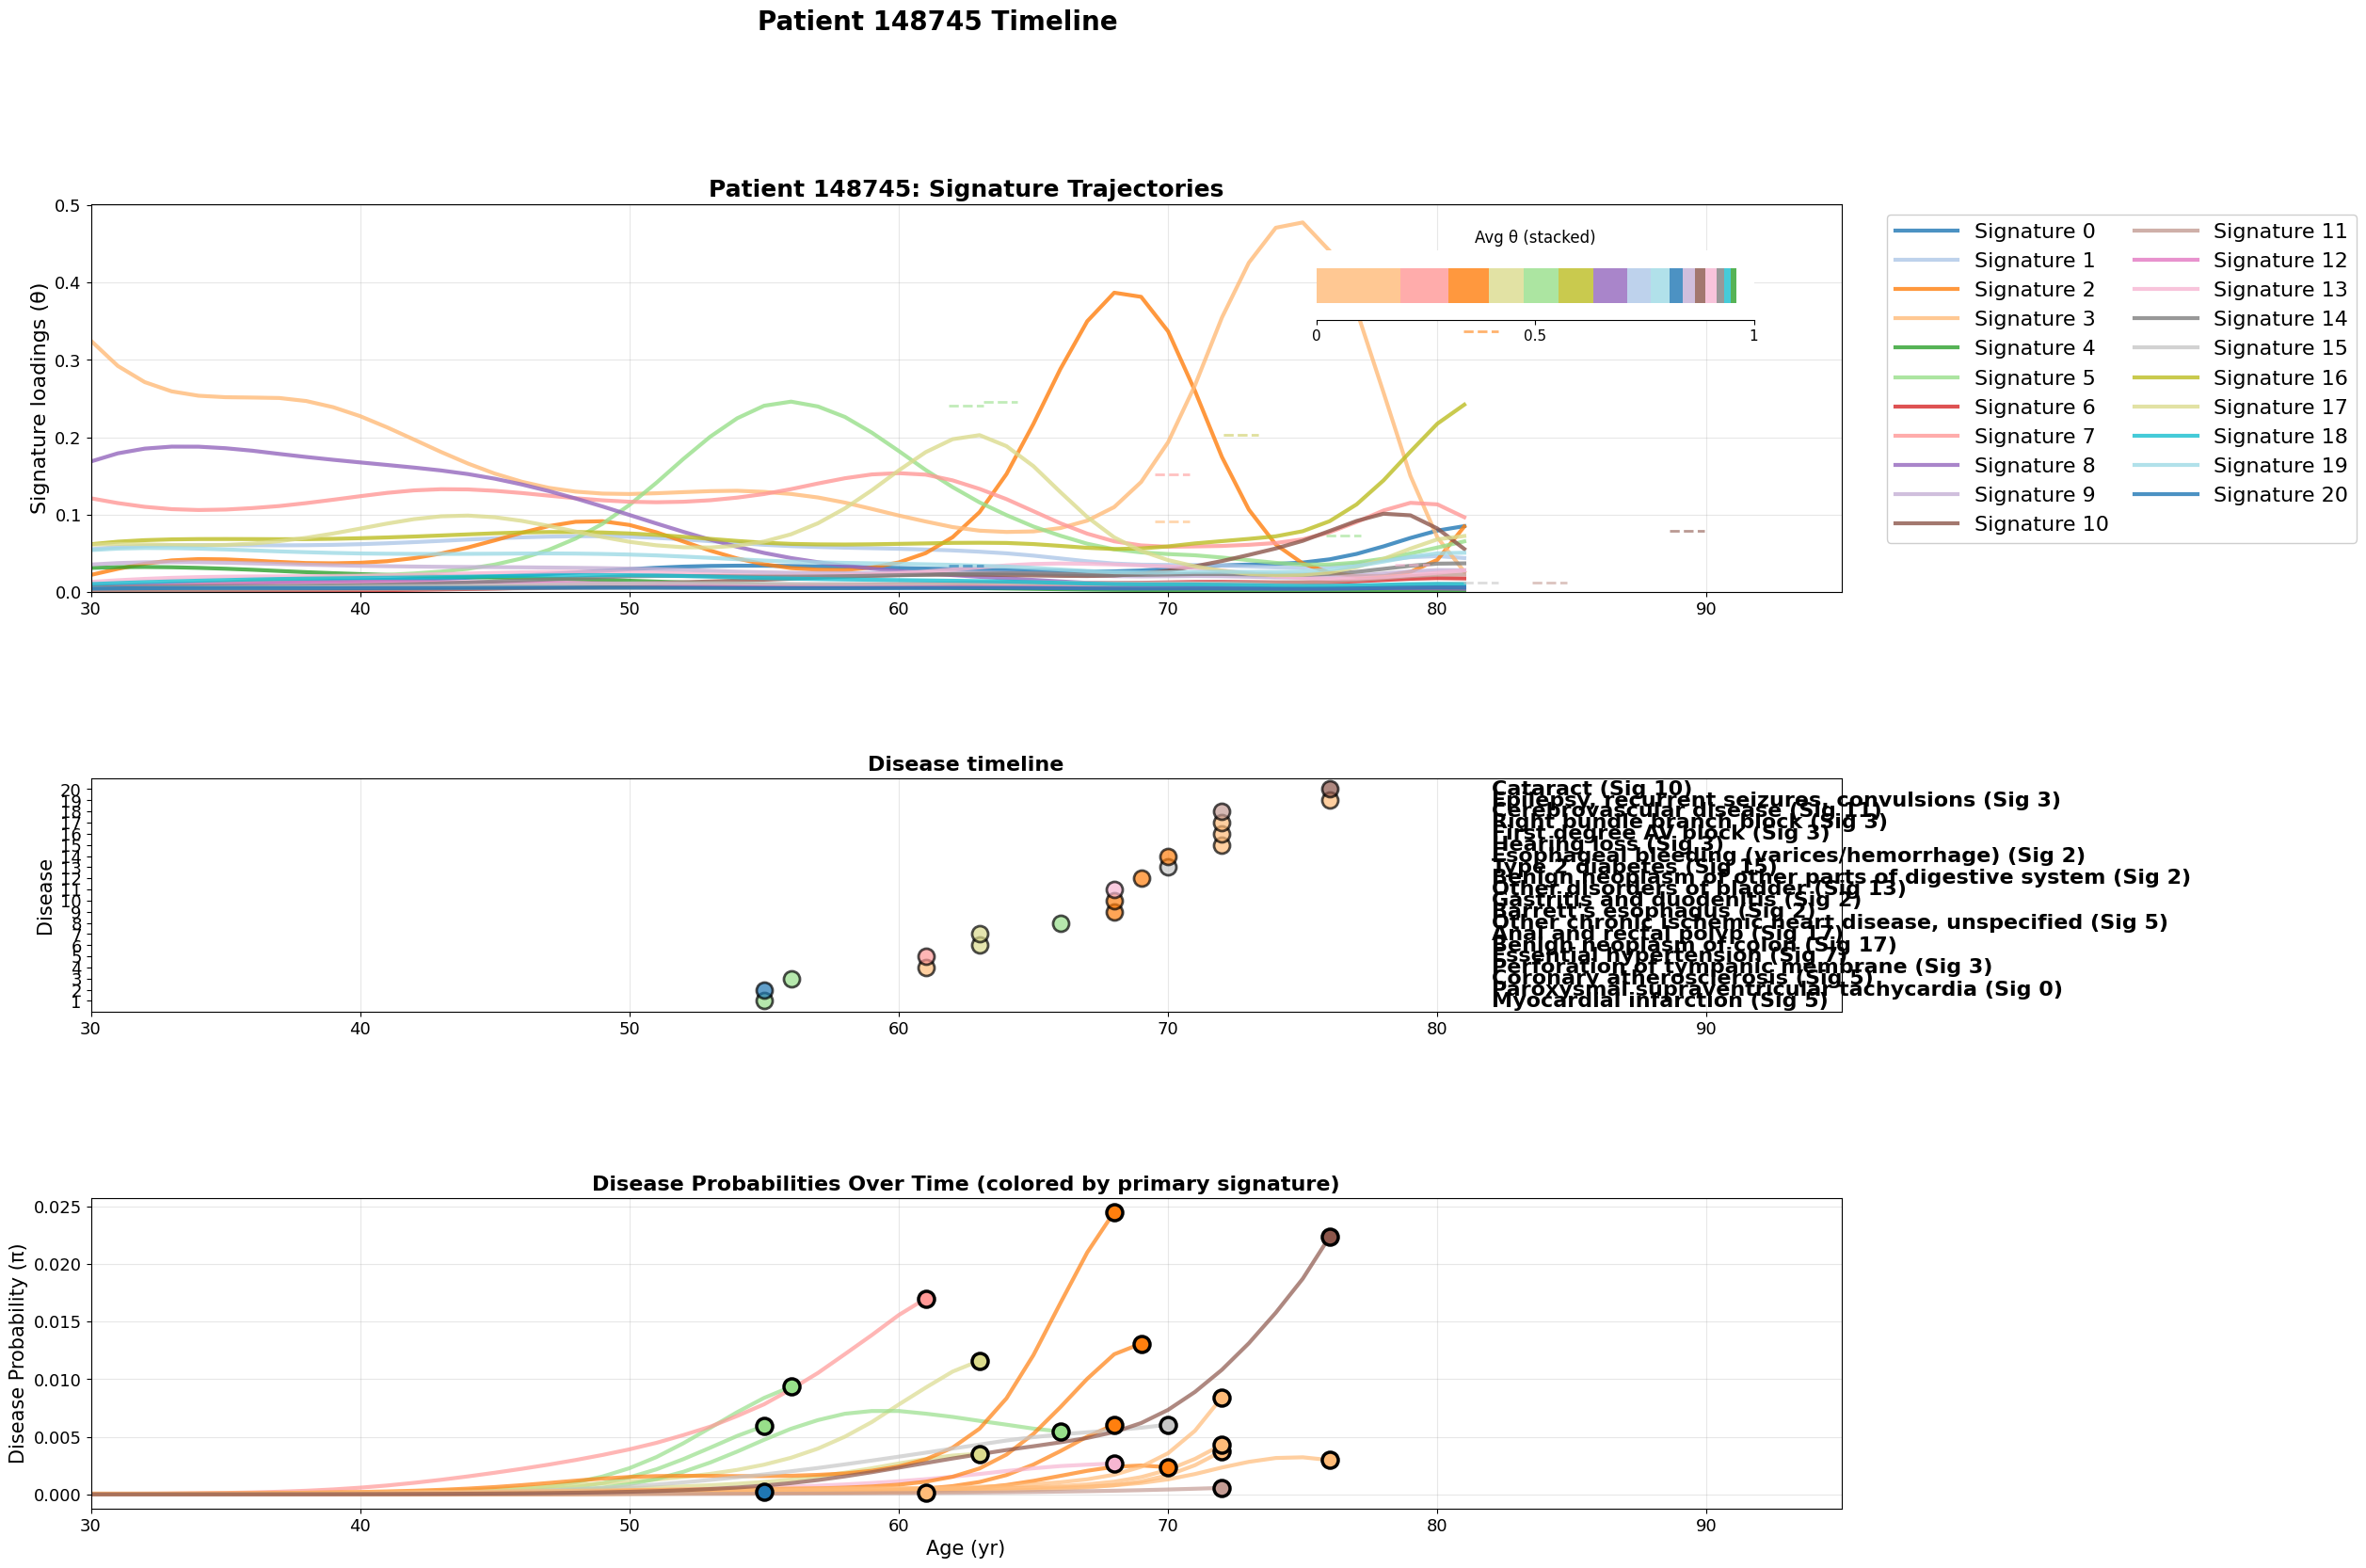

In [13]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/plot_patient_timeline.py

Theta shape: (400000, 21, 52)
Y shape: (407878, 348, 52)
Pi shape: (400000, 348, 52)

Requested patient index: 148745

Using T = 52 (aligned across all arrays)

Patient 148745 Summary:
  Number of diseases: 20
  Diagnosis timepoints: [25, 26, 31, 33, 36, 38, 39, 40, 42, 46]
  Time range: 25 to 46 (ages 55 to 76)

DISEASE DETAILS FOR PATIENT 148745
 1. Myocardial infarction                               Sig  5, Age 55
 2. Paroxysmal supraventricular tachycardia             Sig  0, Age 55
 3. Coronary atherosclerosis                            Sig  5, Age 56
 4. Perforation of tympanic membrane                    Sig  3, Age 61
 5. Essential hypertension                              Sig  7, Age 61
 6. Benign neoplasm of colon                            Sig 17, Age 63
 7. Anal and rectal polyp                               Sig 17, Age 63
 8. Other chronic ischemic heart disease, unspecified   Sig  5, Age 66
 9. Barrett's esophagus                                 Sig  2, Age 68
10. Gastrit

/Users/sarahurbut/Downloads/plot_patient_timeline_v3.py:466: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])



✓ Saved improved plot to: /Users/sarahurbut/aladynoulli2/patient_148745_timeline_v3.pdf


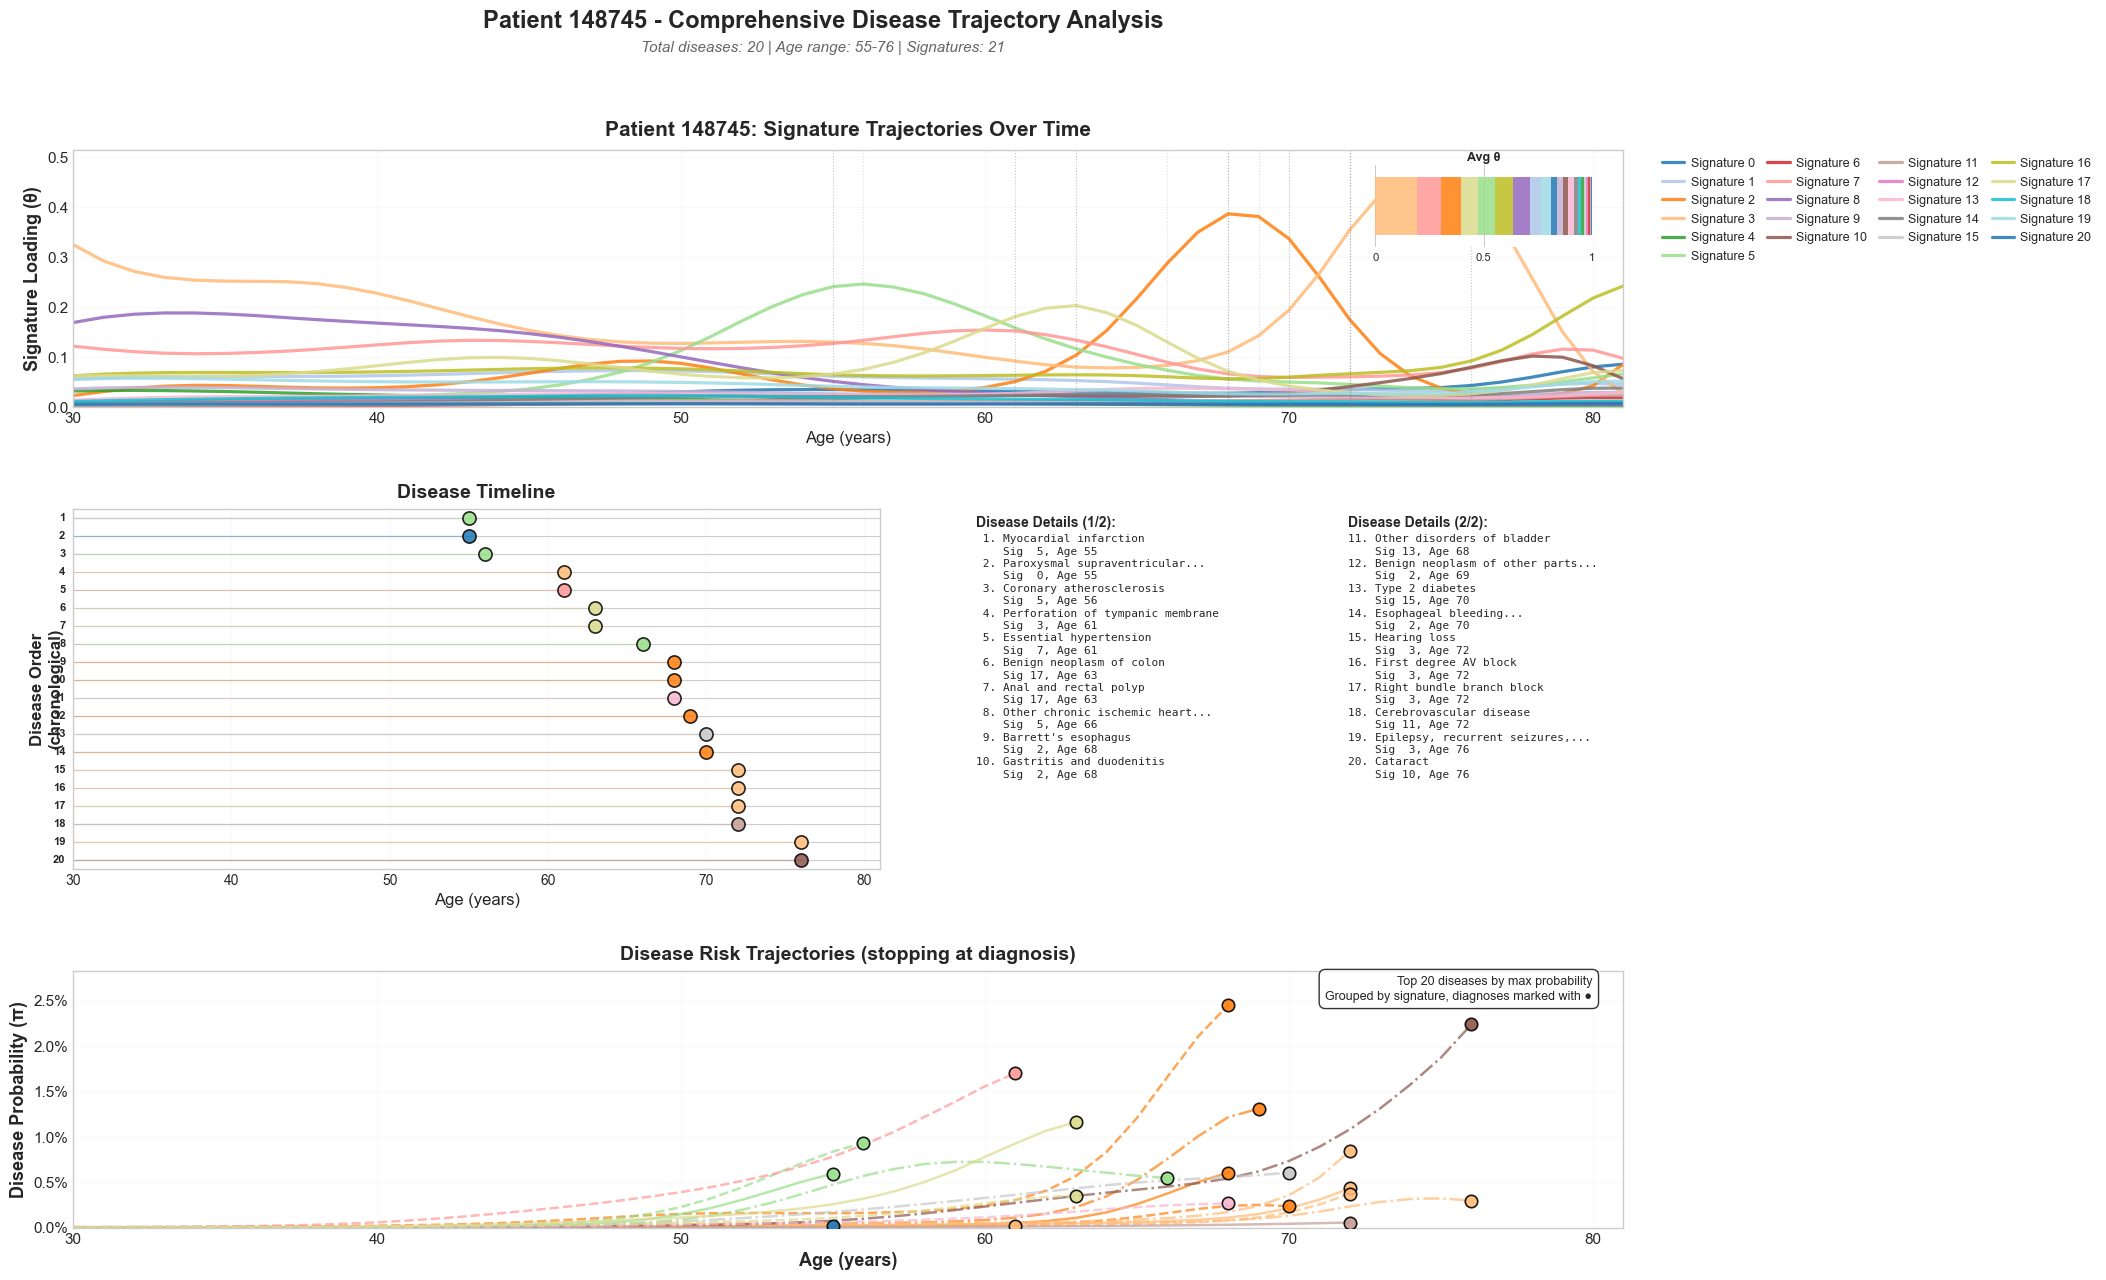

In [1]:
%run /Users/sarahurbut/Downloads/plot_patient_timeline_v3.py

In [24]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/'

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from BATCH DIRECTORY (will average across batches)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/
Pattern: enrollment_model_W0.0001_batch_*_*.pt
Found 40 batch checkpoints. Loading gamma...
  Loaded gamma from enrollment_model_W0.0001_batch_0_10000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_100000_110000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_10000_20000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_110000_120000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_120000_130000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_130000_14000

In [ ]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/'

In [43]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_noSEX' --output_dir "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_noSEX" --pattern "enrollment_model_VECTORIZED_W0.0001_batch_*_*.pt"

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_noSEX
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from BATCH DIRECTORY (will average across batches)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_noSEX
Pattern: enrollment_model_VECTORIZED_W0.0001_batch_*_*.pt
Found 8 batch checkpoints. Loading gamma...
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_0_10000.pt (shape: (46, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_10000_20000.pt (shape: (46, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_20000_30000.pt (shape: (46, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_30000_40000.pt (shape: (46, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_40000_50000.pt (shape: (46

In [44]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized'   --output_dir "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_newestE_PCs_Sex" 


Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_newestE_PCs_Sex
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from BATCH DIRECTORY (will average across batches)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized
Pattern: enrollment_model_W0.0001_batch_*_*.pt
Found 40 batch checkpoints. Loading gamma...
  Loaded gamma from enrollment_model_W0.0001_batch_0_10000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_100000_110000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_10000_20000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_110000_120000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_120000_130000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_bat

In [26]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py \
  --old_results_dir "/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/resultshighamp/results" \
  --output_dir "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_oldpaper" \
  --n_top 30

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_oldpaper
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from OLD FOLDER STRUCTURE (results/output_*_*/model.pt)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/resultshighamp/results
Found 40 model files. Loading gamma...
  Loaded gamma from output_0_10000/model.pt (shape: (36, 21))
  Loaded gamma from output_100000_110000/model.pt (shape: (36, 21))
  Loaded gamma from output_10000_20000/model.pt (shape: (36, 21))
  Loaded gamma from output_110000_120000/model.pt (shape: (36, 21))
  Loaded gamma from output_120000_130000/model.pt (shape: (36, 21))
  Loaded gamma from output_130000_140000/model.pt (shape: (36, 21))
  Loaded gamma from output_140000_150000/model.pt (shape: (36, 21))
  Loaded gamma from output_150000_160000/model.pt (sha

In [45]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir "/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full" --pattern "enrollment_model_W0.0001_batch_*_*.pt" --output_dir "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_october_no_E_withPCSSEX" --n_top 30

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_october_no_E_withPCSSEX
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from BATCH DIRECTORY (will average across batches)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full
Pattern: enrollment_model_W0.0001_batch_*_*.pt
Found 40 batch checkpoints. Loading gamma...
  Loaded gamma from enrollment_model_W0.0001_batch_0_10000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_100000_110000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_10000_20000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_110000_120000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0.0001_batch_120000_130000.pt (shape: (47, 21))
  Loaded gamma from enrollment_model_W0

In [38]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/generate_prs_signature_plots.py --batch_dir "/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_noPCS/" --pattern "enrollment_model_VECTORIZED_W0.0001_batch_*_*.pt" --output_dir "/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_nopPCS_E" --n_top 30

Output directory: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/prs_signatures_nopPCS_E
Loaded 36 PRS names from: /Users/sarahurbut/aladynoulli2/prs_names.csv

Loaded 36 PRS names
  First few: ['AAM', 'AMD', 'AD', 'AST', 'AF']

METHOD: Loading gamma from BATCH DIRECTORY (will average across batches)
Directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_noPCS/
Pattern: enrollment_model_VECTORIZED_W0.0001_batch_*_*.pt
Found 40 batch checkpoints. Loading gamma...
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_0_10000.pt (shape: (37, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_100000_110000.pt (shape: (37, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_10000_20000.pt (shape: (37, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_110000_120000.pt (shape: (37, 21))
  Loaded gamma from enrollment_model_VECTORIZED_W0.0001_batch_120000_130000.pt 

In [46]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/compare_gamma_versions.py

✓ Loaded March (loop, no sex, no PCs, wrong E): 756 associations
✓ Loaded October (loop, sex+PCs, wrong E): 756 associations
✓ Loaded Current (vector, sex+PCs, correct E): 756 associations
✓ Loaded No PCs (vector, sex, correct E): 756 associations
✓ Loaded No Sex (vector, PCs, correct E): 756 associations

SUMMARY STATISTICS BY VERSION
                              version  mean_abs_effect  median_abs_effect  max_abs_effect  std_abs_effect  mean_sem  median_sem  n_associations
March (loop, no sex, no PCs, wrong E)         0.006427           0.002957        0.227226        0.015062  0.002619    0.002501             720
     October (loop, sex+PCs, wrong E)         0.000192           0.000075        0.006314        0.000474  0.000051    0.000051             720
 Current (vector, sex+PCs, correct E)         0.000192           0.000076        0.006294        0.000472  0.000051    0.000051             720
      No PCs (vector, sex, correct E)         0.000192           0.000076        0.006

In [47]:
loop=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_loop/enrollment_model_LOOP_W0.0001_batch_0_10000.pt')

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_61158/914318585.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loop=torch.load('/Users/sarahurbut/Library/Clo

In [48]:
loop['model_state_dict']['gamma']

tensor([[-1.3943e-04, -3.0508e-04,  3.7368e-04,  2.9208e-04, -4.0898e-04,
          3.3393e-04,  2.3710e-04, -2.9065e-05, -1.6657e-04,  6.5052e-04,
         -3.0021e-04,  8.7666e-05,  2.5828e-04,  3.3470e-05,  1.4270e-04,
          2.6332e-04,  8.4753e-05,  4.9376e-04, -4.4078e-04,  1.1673e-04,
          0.0000e+00],
        [ 5.6279e-05, -1.7399e-04, -9.6096e-05,  5.1037e-04, -1.1554e-04,
          6.3781e-04,  9.4294e-05,  1.5299e-04,  1.3995e-05, -1.8448e-04,
          1.6525e-04,  2.5502e-04, -2.3803e-04, -1.2069e-04,  1.9267e-04,
         -2.1922e-05, -2.4083e-04, -7.7505e-04, -5.0192e-05,  1.0205e-03,
          0.0000e+00],
        [-3.4964e-04,  1.2337e-04, -1.3207e-04,  3.8746e-04,  3.2881e-04,
          8.9723e-04, -1.1993e-05, -4.5287e-04,  2.7332e-04, -3.7522e-04,
         -3.9698e-04,  3.1321e-04,  3.1676e-05, -2.5746e-05, -9.0354e-05,
          8.2513e-05,  9.2958e-04, -8.6816e-05, -2.2528e-04, -2.7147e-04,
          0.0000e+00],
        [ 7.4388e-04,  2.9203e-04,  2.4666e

In [49]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/main_paper_figures/compare_gamma_versions.py 2>&1 | head -100

✓ Loaded March (loop, no sex, no PCs, wrong E): 756 associations
✓ Loaded October (loop, sex+PCs, wrong E): 756 associations
✓ Loaded Current (vector, sex+PCs, correct E): 756 associations
✓ Loaded No PCs (vector, sex, correct E): 756 associations
✓ Loaded No Sex (vector, PCs, correct E): 756 associations

SUMMARY STATISTICS BY VERSION
                              version  mean_abs_effect  median_abs_effect  max_abs_effect  std_abs_effect  mean_sem  median_sem  n_associations
March (loop, no sex, no PCs, wrong E)         0.006427           0.002957        0.227226        0.015062  0.002619    0.002501             720
     October (loop, sex+PCs, wrong E)         0.000192           0.000075        0.006314        0.000474  0.000051    0.000051             720
 Current (vector, sex+PCs, correct E)         0.000192           0.000076        0.006294        0.000472  0.000051    0.000051             720
      No PCs (vector, sex, correct E)         0.000192           0.000076        0.006

In [1]:
from analyze_age_onset import analyze_age_onset_patterns

early_indices, late_indices, stats = analyze_age_onset_patterns(
    results_base_dir='/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized',
    disease_index=113,  # MI
    early_threshold=55,
    late_threshold=70,
    output_path='/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/fig3/mi_onset_patterns_all_batches.pdf',  # optional
    return_stats=True
)


Analyzing Age Onset Patterns
Results directory: /Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized
Disease index: 113
Early threshold: <55 years
Late threshold: >70 years

Found 40 batch files

Processing enrollment_model_W0.0001_batch_0_10000.pt (patients 0 to 10000)...
  Found: 101 early, 192 late
Processing enrollment_model_W0.0001_batch_10000_20000.pt (patients 10000 to 20000)...
  Found: 85 early, 199 late
Processing enrollment_model_W0.0001_batch_20000_30000.pt (patients 20000 to 30000)...
  Found: 90 early, 196 late
Processing enrollment_model_W0.0001_batch_30000_40000.pt (patients 30000 to 40000)...
  Found: 92 early, 199 late
Processing enrollment_model_W0.0001_batch_40000_50000.pt (patients 40000 to 50000)...
  Found: 89 early, 220 late
Processing enrollment_model_W0.0001_batch_50000_60000.pt (patients 50000 to 60000)...
  Found: 73 early, 174 late
Processing enrollment_model_W0.0001_batch_60000_70000.pt (patients 60000 to 70000)...
  Found: 85 early

Loaded data: N=10000, K=21, T=52
Found disease 'Myocardial infarction' at index 112
Saved figure to /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/fig3/contribution_breakdown_Myocardial_infarction_ind100_newestE.pdf


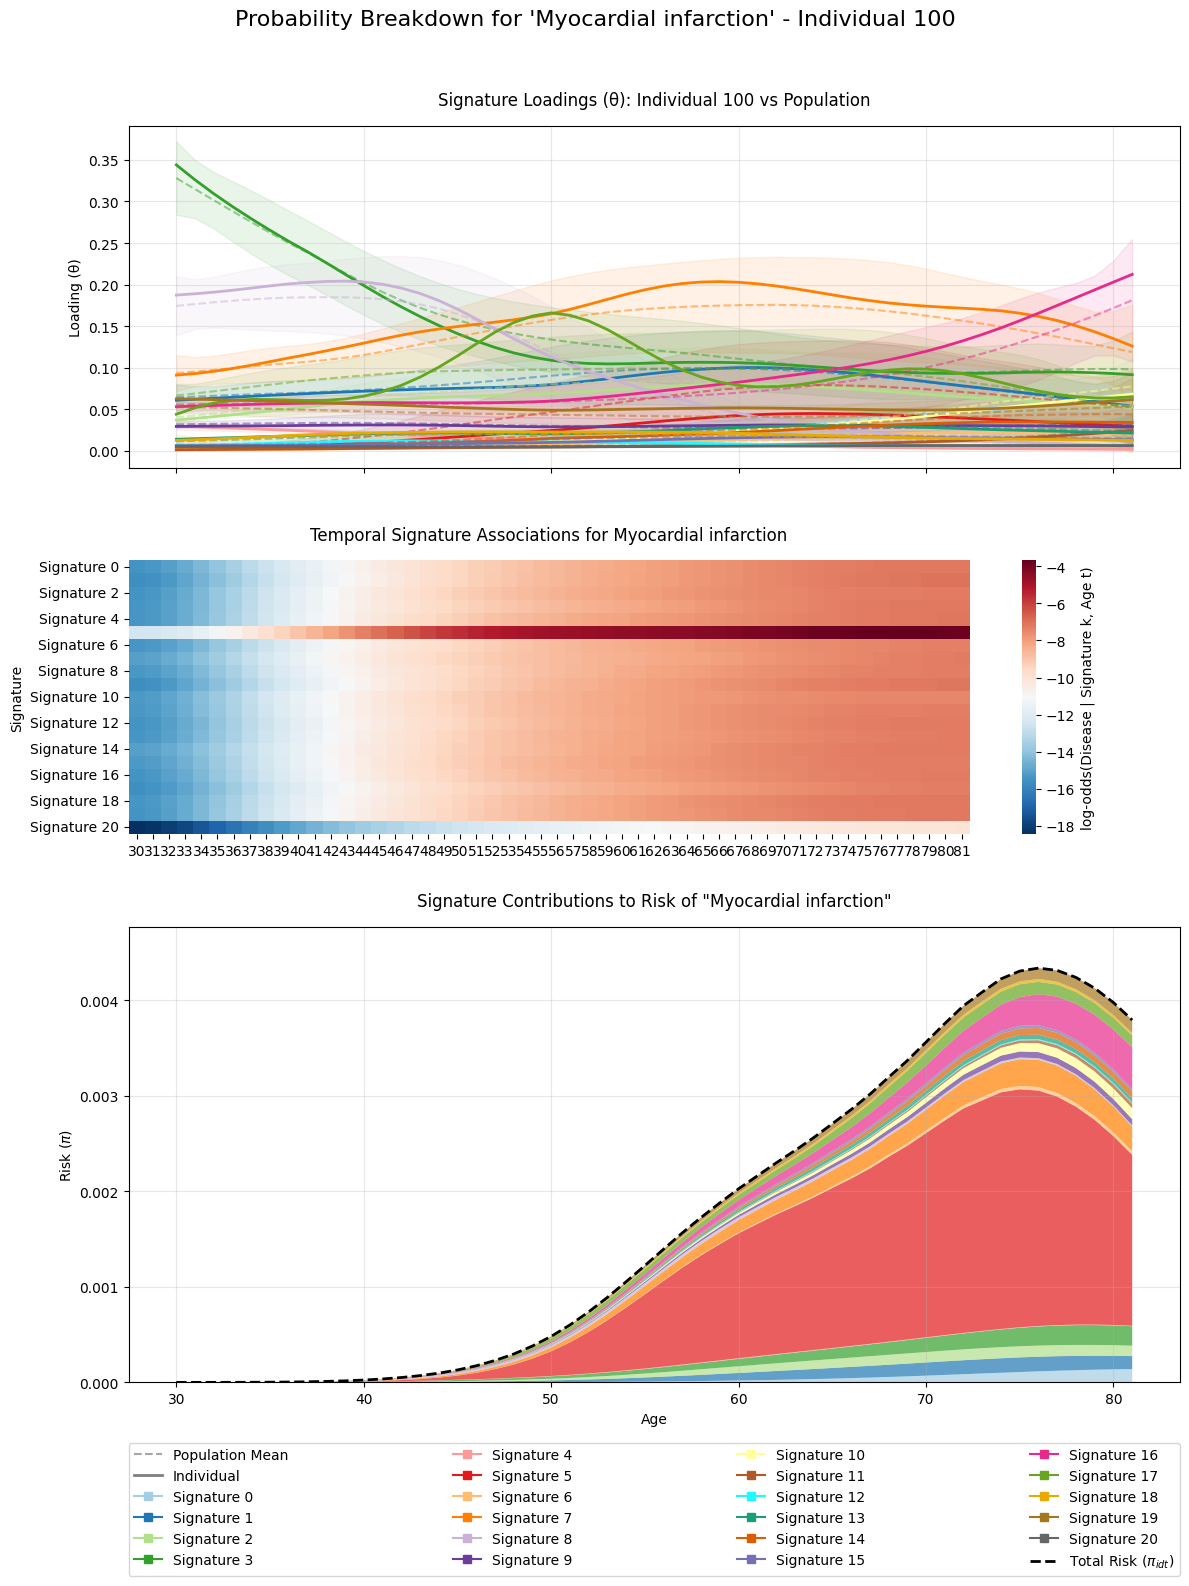

In [1]:
# ============================================================================
# Disease Contribution Breakdown Visualization (using newest thetas)
# ============================================================================
from matplotlib.lines import Line2D
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from fig3_utils import visualize_disease_contribution_breakdown_new
import torch
import numpy as np
import pandas as pd

# Load checkpoint from newest censor_e_batchrun_vectorized
checkpoint_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized/enrollment_model_W0.0001_batch_0_10000.pt'
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

# Extract lambda and phi
lambda_values_np = checkpoint['model_state_dict']['lambda_'].detach().cpu().numpy()
phi_values_np = checkpoint['model_state_dict']['phi'].detach().cpu().numpy()

# Load disease names
disease_names = checkpoint.get('disease_names', None)
if disease_names is None:
    disease_names = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/disease_names.csv')['x'].tolist()
elif isinstance(disease_names, pd.DataFrame):
    disease_names = disease_names.iloc[:, 0].tolist()
elif isinstance(disease_names, pd.Index):
    disease_names = disease_names.tolist()
elif isinstance(disease_names, pd.Series):
    disease_names = disease_names.tolist()

# Get dimensions
N, K, T = lambda_values_np.shape
print(f"Loaded data: N={N}, K={K}, T={T}")

# Define target disease and individual
target_disease_name = "Myocardial infarction"
try:
    target_disease_idx = disease_names.index(target_disease_name)
    print(f"Found disease '{target_disease_name}' at index {target_disease_idx}")
except ValueError:
    print(f"Error: Could not find disease '{target_disease_name}' in the disease list.")
    print(f"Available diseases (first 10): {disease_names[:10]}")
    raise

# Select individual (you can change this)
individual_to_plot = 100  # Or use high_sig5_individual from earlier cells

# Optional: Use signature mapping if signatures 4 and 5 are swapped in visualization
# signature_mapping = {4: 5, 5: 4}  # Uncomment if needed

# Generate the visualization
visualize_disease_contribution_breakdown_new(
    lambda_values_np=lambda_values_np,
    phi_values_np=phi_values_np,
    individual_idx=individual_to_plot,
    disease_idx=target_disease_idx,
    disease_name=target_disease_name,
    time_points=np.arange(30, 30 + T),
    kappa=checkpoint['model_state_dict']['kappa'],
    output_path=f'/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/paper_figs/fig3/contribution_breakdown_{target_disease_name.replace(" ","_")}_ind{individual_to_plot}_newestE.pdf')